In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns


# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/flight-delay-prediction/delays.csv
/kaggle/input/flight-delay-prediction/data.csv


In [57]:
df_temp = pd.read_csv('/kaggle/input/flight-delay-prediction/data.csv', index_col=False, nrows=10)
for column in df_temp.columns:
    print(column)

Year
Quarter
Month
DayofMonth
DayOfWeek
FlightDate
Marketing_Airline_Network
Operated_or_Branded_Code_Share_Partners
DOT_ID_Marketing_Airline
IATA_Code_Marketing_Airline
Flight_Number_Marketing_Airline
Originally_Scheduled_Code_Share_Airline
DOT_ID_Originally_Scheduled_Code_Share_Airline
IATA_Code_Originally_Scheduled_Code_Share_Airline
Flight_Num_Originally_Scheduled_Code_Share_Airline
Operating_Airline 
DOT_ID_Operating_Airline
IATA_Code_Operating_Airline
Tail_Number
Flight_Number_Operating_Airline
OriginAirportID
OriginAirportSeqID
OriginCityMarketID
Origin
OriginCityName
OriginState
OriginStateFips
OriginStateName
OriginWac
DestAirportID
DestAirportSeqID
DestCityMarketID
Dest
DestCityName
DestState
DestStateFips
DestStateName
DestWac
CRSDepTime
DepTime
DepDelay
DepDelayMinutes
DepDel15
DepartureDelayGroups
DepTimeBlk
TaxiOut
WheelsOff
WheelsOn
TaxiIn
CRSArrTime
ArrTime
ArrDelay
ArrDelayMinutes
ArrDel15
ArrivalDelayGroups
ArrTimeBlk
Cancelled
CancellationCode
Diverted
CRSElapsedTime

In [25]:
df = pd.read_csv('/kaggle/input/flight-delay-prediction/data.csv', index_col=False, usecols=['Year', 'Month', 'Origin'])
delays = pd.read_csv('/kaggle/input/flight-delay-prediction/delays.csv', index_col=False, usecols=['Year', 'DepDelay'])

In [47]:
delays

,Year,DepDelay
0,2020,0.0
1,2020,0.0
2,2020,0.0
3,2020,0.0
4,2020,0.0
...,...,...
38426823,2020,0.0
38426824,2020,0.0
38426825,2020,0.0
38426826,2020,0.0


In [34]:
df

,Year,Month,Origin
0,2020,8,ATL
1,2020,8,SAN
2,2020,8,ORF
3,2020,8,LAX
4,2020,8,SAN
...,...,...,...
38426823,2020,7,MOT
38426824,2020,7,ABE
38426825,2020,7,SFB
38426826,2020,7,ABE


In [26]:
delays['DepDelay'] = delays['DepDelay'].apply(lambda x: max(0, x))

merged_df = pd.merge(df, delays, left_index=True, right_index=True)

# filtered_df = merged_df[merged_df['DepDelay'] > 0]

In [120]:
result_df = merged_df.groupby('Origin').agg({
    'Origin': 'count',
    'DepDelay': ['sum', lambda x: (x > 0).sum()]
}).reset_index()

# Flatten the MultiIndex columns
result_df.columns = ['Origin', 'Count', 'Sum_DepDelay', 'Count_Positive_DepDelay']

print(result_df)

    Origin   Count  Sum_DepDelay  Count_Positive_DepDelay
0      ABE   29171      395398.0                     7087
1      ABI   10943      129954.0                     2642
2      ABQ  121954     1317366.0                    39214
3      ABR    4086       58548.0                      810
4      ABY    5281       58224.0                      943
..     ...     ...           ...                      ...
384    XWA    5026       86341.0                     1156
385    YAK    4038       30402.0                      980
386    YKM    4773       36681.0                     1295
387    YNG       2         126.0                        2
388    YUM    9341      101381.0                     1892

[389 rows x 4 columns]


Need to discuss which quantiles to use. From the box plot, we can see that the deviation for different tags is different. Maybe a better output can be found if we can think of a better quantiles or maybe divide the data into more than 3 sections. Can use elboe method to determine the optimal amount of clusters (number of groups)

In [121]:
result_df = result_df.sort_values(by='Count', ascending=False)

# Calculate quartiles
q25, q75 = result_df['Count'].quantile([0.25, 0.75])

# Function to assign tags based on quartiles
def tag_quartile(count):
    if count <= q25:
        return 0
    elif q25 < count <= q75:
        return 1
    else:
        return 2

# Create a new column 'Tag' based on quartiles
result_df['Tag'] = result_df['Count'].apply(tag_quartile)

# Print the sorted and tagged result
print(result_df)


    Origin    Count  Sum_DepDelay  Count_Positive_DepDelay  Tag
23     ATL  1861668    17396674.0                   610566    2
266    ORD  1761105    22688277.0                   557116    2
100    DFW  1534384    20262460.0                   539927    2
99     DEN  1476970    21311790.0                   618345    2
77     CLT  1255581    13076846.0                   387690    2
..     ...      ...           ...                      ...  ...
35     BFM      205        2700.0                       51    0
179    ILG      165        4208.0                       79    0
315    ROP      151         240.0                       19    0
178    IFP       45         195.0                       15    0
387    YNG        2         126.0                        2    0

[389 rows x 5 columns]


In [122]:
result_df['Percentage_Delayed'] = (result_df['Count_Positive_DepDelay'] / result_df['Count']) * 100


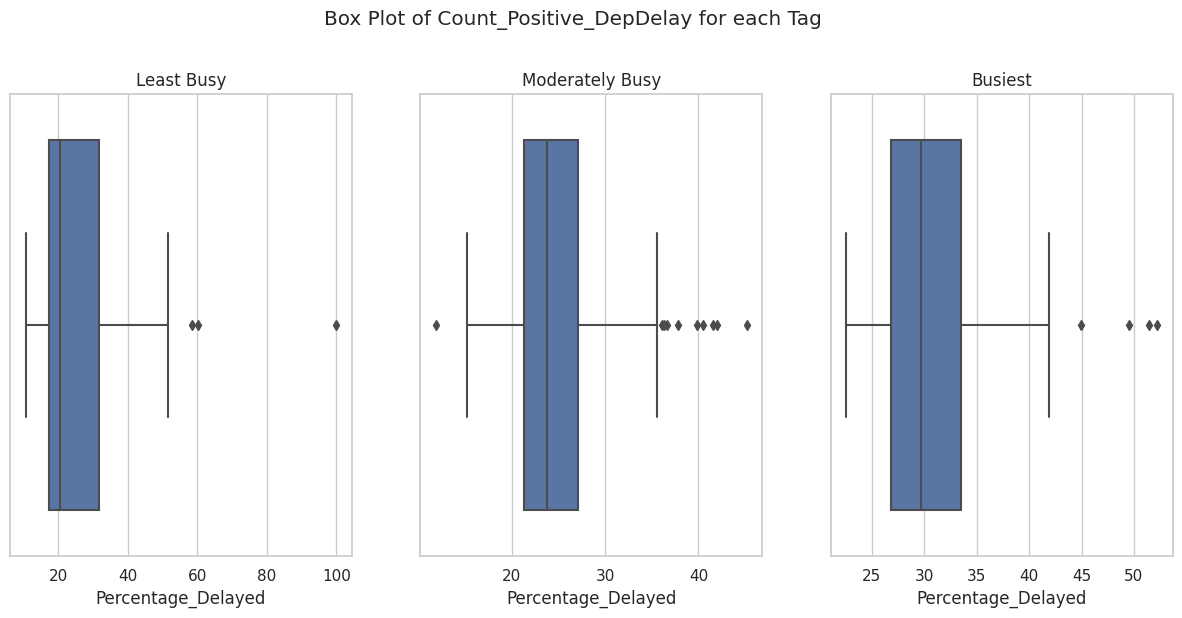

In [123]:
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming your DataFrame is named 'result_df'
# Make sure to replace the column names accordingly if they are different

# Separate the DataFrame into three based on 'Tag' values
tag1_df = result_df[result_df['Tag'] == 0]
tag2_df = result_df[result_df['Tag'] == 1]
tag3_df = result_df[result_df['Tag'] == 2]

# Set up the subplots
fig, axes = plt.subplots(1, 3, figsize=(15, 6), sharey=True)

# Plot boxplots for each Tag value
sns.boxplot(x='Percentage_Delayed', data=tag1_df, ax=axes[0])
axes[0].set_title('Least Busy')

sns.boxplot(x='Percentage_Delayed', data=tag2_df, ax=axes[1])
axes[1].set_title('Moderately Busy')

sns.boxplot(x='Percentage_Delayed', data=tag3_df, ax=axes[2])
axes[2].set_title('Busiest')

# Set a common title for all subplots
plt.suptitle('Box Plot of Count_Positive_DepDelay for each Tag', y=1.02)

plt.show()


As seen from the box plots above, there are a few outliers in each label which can distrot the mean. Hence median should be a better representative value for this purpose.

In [126]:
tag_2_avg = result_df.loc[result_df['Tag'] == 2, 'Percentage_Delayed'].median()
tag_1_avg = result_df.loc[result_df['Tag'] == 1, 'Percentage_Delayed'].median()
tag_0_avg = result_df.loc[result_df['Tag'] == 0, 'Percentage_Delayed'].median()

# Print the results
print(f"Average Count_Positive_DepDelay for Tag 2: {tag_2_avg}")
print(f"Average Count_Positive_DepDelay for Tag 1: {tag_1_avg}")
print(f"Average Count_Positive_DepDelay for Tag 0: {tag_0_avg}")

Average Count_Positive_DepDelay for Tag 2: 29.73179832254361
Average Count_Positive_DepDelay for Tag 1: 23.772233619573917
Average Count_Positive_DepDelay for Tag 0: 20.553958120073958


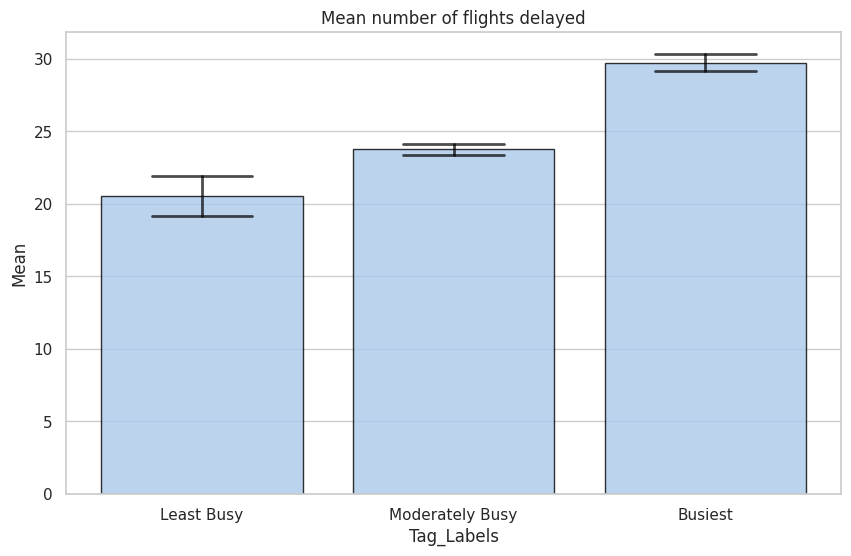

In [129]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Assuming your DataFrame is named 'result_df'
# Make sure to replace the column names accordingly if they are different

# Calculate mean and standard deviation for each tag value
tag_means = result_df.groupby('Tag')['Percentage_Delayed'].median()
tag_std_devs = result_df.groupby('Tag')['Percentage_Delayed'].std()

# Calculate standard error of the mean (SEM)
tag_sems = tag_std_devs / np.sqrt(result_df.groupby('Tag')['Percentage_Delayed'].count())

# Create a DataFrame for plotting
plot_data = {'Tag': tag_means.index, 'Mean': tag_means.values, 'SEM': tag_sems.values}
plot_df = pd.DataFrame(plot_data)
tag_labels = {0: "Least Busy", 1: "Moderately Busy", 2: "Busiest"}
plot_df['Tag_Labels'] = plot_df['Tag'].map(tag_labels)

# Plotting
sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))

# Custom color palette
colors = sns.color_palette("pastel")

# Bar plot with error bars using yerr
ax = sns.barplot(x='Tag_Labels', y='Mean', data=plot_df, color=colors[0], edgecolor='black', capsize=0.1, alpha=0.8)

# Add vertical and horizontal lines for better appearance
for i, value in enumerate(tag_means):
    ax.plot([i, i], [value - tag_sems[i], value + tag_sems[i]], color='black', lw=2, alpha=0.7)
    ax.plot([i - 0.2, i + 0.2], [value - tag_sems[i], value - tag_sems[i]], color='black', lw=2, alpha=0.7)
    ax.plot([i - 0.2, i + 0.2], [value + tag_sems[i], value + tag_sems[i]], color='black', lw=2, alpha=0.7)

plt.title('Mean number of flights delayed')
plt.show()

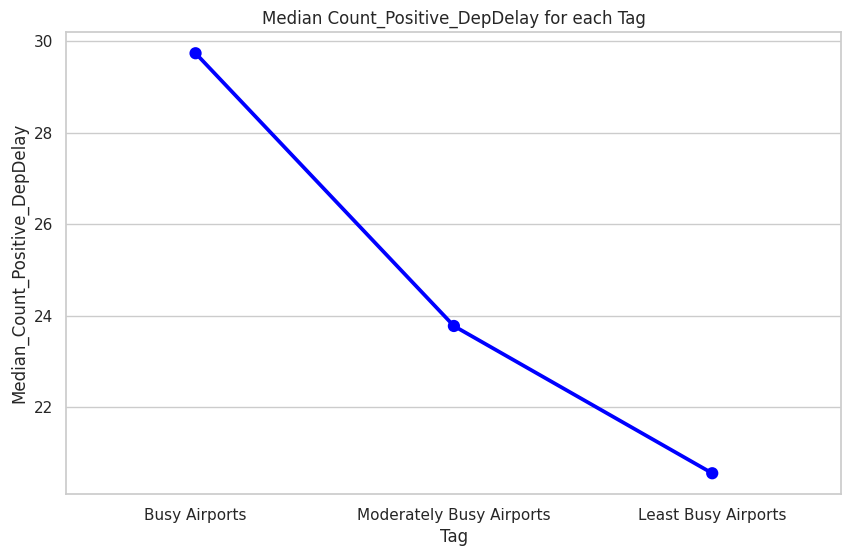

In [130]:
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming your DataFrame is named 'result_df'
# Make sure to replace the column names accordingly if they are different

# Calculate medians for each tag value
tag_2_median = result_df.loc[result_df['Tag'] == 2, 'Percentage_Delayed'].median()
tag_1_median = result_df.loc[result_df['Tag'] == 1, 'Percentage_Delayed'].median()
tag_0_median = result_df.loc[result_df['Tag'] == 0, 'Percentage_Delayed'].median()

# Create a DataFrame for plotting
median_data = {'Tag': ['Busy Airports', 'Moderately Busy Airports', 'Least Busy Airports'],
               'Median_Count_Positive_DepDelay': [tag_2_median, tag_1_median, tag_0_median]}

median_df = pd.DataFrame(median_data)

# Plotting
sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))

# Using a point plot to visualize medians
sns.pointplot(x='Tag', y='Median_Count_Positive_DepDelay', data=median_df, markers='o', color='blue')

plt.title('Median Count_Positive_DepDelay for each Tag')
plt.show()


In [ ]:
heatmap_data = plot_df.pivot(index='Tag_Labels', columns='Tag', values='Mean')

# Plotting heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(heatmap_data, annot=True, fmt=".2f", cmap="YlGnBu", linewidths=0.5, cbar_kws={'label': 'Mean Percentage of Delayed Flights'})
plt.title('Mean Percentage of Delayed Flights Heatmap')
plt.show()

# ---------------------------------------------- Harshil's Part-------------------------------------------------

In [131]:
df = pd.read_csv('/kaggle/input/flight-delay-prediction/data.csv', index_col=False, usecols=['Year', 'Month', 'OriginCityName', 'Marketing_Airline_Network'])
delays = pd.read_csv('/kaggle/input/flight-delay-prediction/delays.csv', index_col=False, usecols=['Year', 'DepDelay'])

In [174]:
delays.columns

Index(['Year', 'DepDelay'], dtype='object')

In [132]:
# Count the number of unique airlines
unique_airlines = df['Marketing_Airline_Network'].nunique()

In [133]:
# Calculate relative counts and median delay by airline
airline_counts = df['Marketing_Airline_Network'].value_counts()
relative_counts = airline_counts / len(df)

delays['DepDelay'] = delays['DepDelay'].apply(lambda x: max(0, x))

merged_df = pd.merge(df, delays, left_index=True, right_index=True)

filtered_df = merged_df[merged_df['DepDelay'] > 0]

delay_by_airline = filtered_df.groupby('Marketing_Airline_Network')['DepDelay'].mean()

In [134]:
# Sort the dataframes for plotting
relative_counts = relative_counts.sort_index()
delay_by_airline = delay_by_airline.sort_index()

In [135]:
threshold = relative_counts.quantile(0.70)

# Categorize airlines based on the threshold
large_airlines = list(relative_counts[relative_counts >= threshold].index)
small_airlines = list(relative_counts[relative_counts < threshold].index)

# Display the counts and lists of small and large airlines
print("Large Airlines (top quartile):", large_airlines)
print("Small Airlines (bottom three quartiles):", small_airlines)

Large Airlines (top quartile): ['AA', 'DL', 'UA', 'WN']
Small Airlines (bottom three quartiles): ['AS', 'B6', 'F9', 'G4', 'HA', 'NK', 'VX']


I used the quantile method, specifically the 0.7 quantile, to objectively determine a threshold for categorizing airlines as "large" or "small" based on their relative counts. By selecting the 0.7 quantile, I identified the top 30% of airlines with the highest relative counts. In our context, "relative count" refers to the proportion of flights operated by each airline in relation to the total number of flights in the dataset. This approach helps me establish a data-driven criterion for distinguishing the airlines that significantly contribute to air traffic (the "large" airlines) from the ones with lower relative counts (the "small" airlines). By setting the threshold at the 0.7 quantile, I'm able to focus on the airlines that collectively represent a substantial portion of the data, making the categorization more meaningful and aligned with the observed distribution in the dataset.

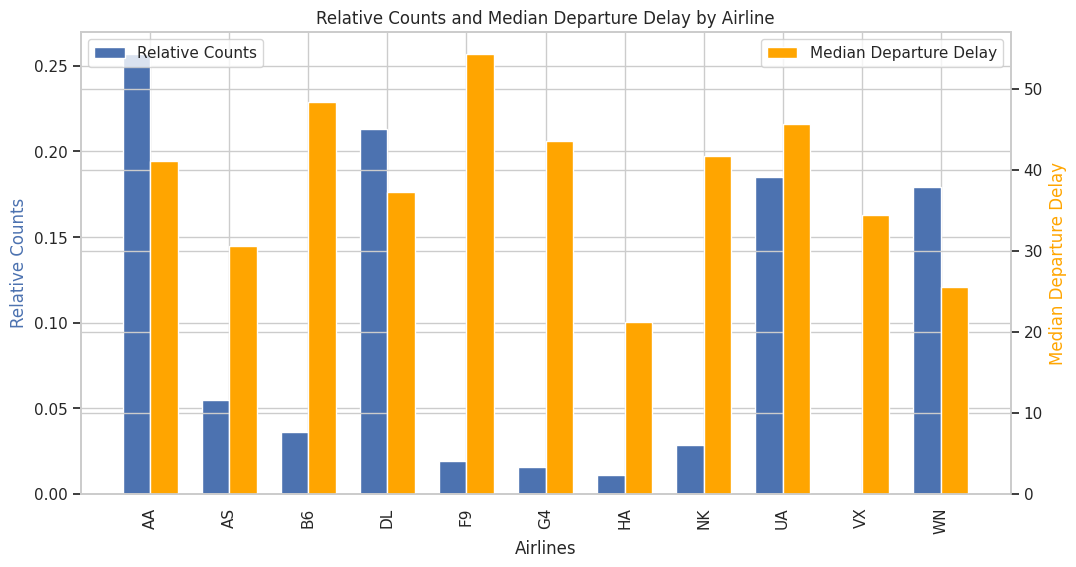

In [136]:
# Create a figure and axis
fig, ax1 = plt.subplots(figsize=(12, 6))

# Create an array of x values for the bars
x = range(len(relative_counts))

# Set the bar width
bar_width = 0.35

# Plot Relative Counts on the primary y-axis
ax1.bar(x, relative_counts.values, bar_width, color='b', label='Relative Counts')
ax1.set_xlabel('Airlines')
ax1.set_ylabel('Relative Counts', color='b')
ax1.set_xticks([i + bar_width / 2 for i in x])
ax1.set_xticklabels(relative_counts.index, rotation=90)

# Create a secondary y-axis for Median Departure Delay
ax2 = ax1.twinx()
ax2.bar([i + bar_width for i in x], delay_by_airline.values, bar_width, color='orange', label='Median Departure Delay')
ax2.set_ylabel('Median Departure Delay', color='orange')

# Set the title
plt.title('Relative Counts and Median Departure Delay by Airline')

# Add a legend
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

# Save the plot to a PDF
plt.savefig('Relative_Count_and_Median_Delay_by_Airline.pdf')

# Show the plot
plt.show()

In [137]:
from scipy.stats import kruskal
from scipy import stats

In [138]:
def categorize_airline_size(airline_name):
    if airline_name in large_airlines:
        return 'large'
    elif airline_name in small_airlines:
        return 'small'
    else:
        return 'unknown'

In [139]:
filtered_df['Airline_Size'] = filtered_df['Marketing_Airline_Network'].apply(categorize_airline_size)

/tmp/ipykernel_32/1617543504.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['Airline_Size'] = filtered_df['Marketing_Airline_Network'].apply(categorize_airline_size)


In [140]:
large_airlines_delays = filtered_df[filtered_df['Airline_Size'] == 'large']['DepDelay']
small_airlines_delays = filtered_df[filtered_df['Airline_Size'] == 'small']['DepDelay']

In [141]:
t_statistic, p_value = stats.ttest_ind(large_airlines_delays, small_airlines_delays)
alpha = 0.05

In [142]:
if p_value < alpha:
    print("The p-value is less than the significance level, so there is evidence of a significant difference in delay between large and small airlines.")
else:
    print("The p-value is greater than the significance level, so there is no significant difference in delay between large and small airlines.")

The p-value is less than the significance level, so there is evidence of a significant difference in delay between large and small airlines.


**Yearly Trend**

In [143]:
# Calculate relative counts and median departure delay by year
yearly_counts = delays['Year'].value_counts()
relative_counts = yearly_counts / yearly_counts.sum()

delays['DepDelay'] = delays['DepDelay'].apply(lambda x: max(0, x))

delays = delays[delays['DepDelay'] > 0]

delay_by_year = delays.groupby('Year')['DepDelay'].median()

# Sort the dataframes for plotting
relative_counts = relative_counts.sort_index()
delay_by_year = delay_by_year.sort_index()

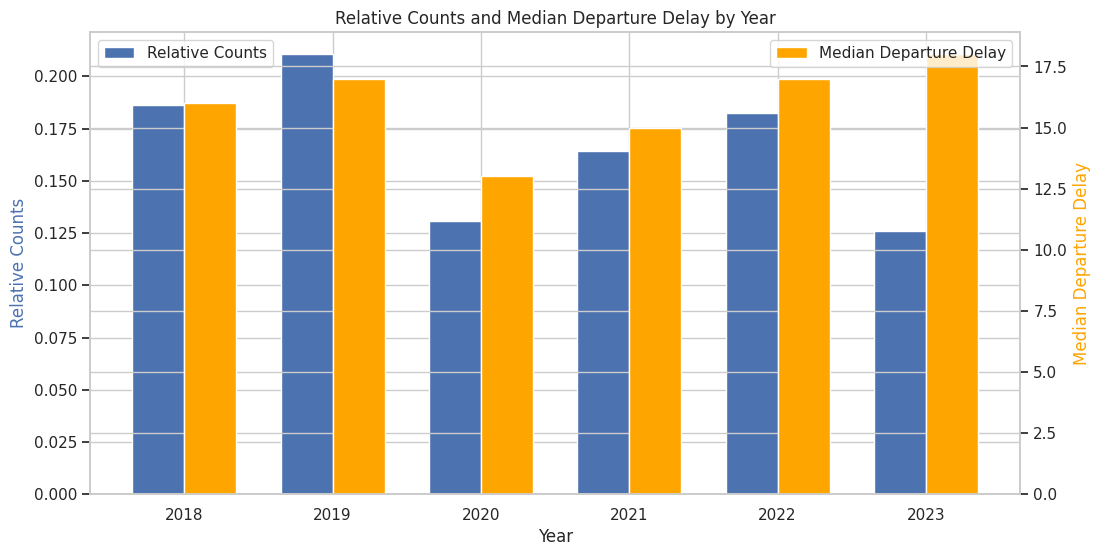

In [144]:
# Create a figure and primary axis
fig, ax1 = plt.subplots(figsize=(12, 6))

# Create an array of x values for the bars
x = range(len(relative_counts))

# Set the bar width
bar_width = 0.35

# Plot Relative Counts on the primary y-axis
ax1.bar(x, relative_counts.values, bar_width, color='b', label='Relative Counts')
ax1.set_xlabel('Year')
ax1.set_ylabel('Relative Counts', color='b')
ax1.set_xticks([i + bar_width / 2 for i in x])
ax1.set_xticklabels(relative_counts.index, rotation=0)

# Create a secondary axis for Median Departure Delay
ax2 = ax1.twinx()
ax2.bar([i + bar_width for i in x], delay_by_year.values, bar_width, color='orange', label='Median Departure Delay')
ax2.set_ylabel('Median Departure Delay', color='orange')

# Set the title
plt.title('Relative Counts and Median Departure Delay by Year')

# Add legends for both axes
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

# Save the plot to a PDF
plt.savefig('Relative_Count_and_Median_Delay_by_Year.pdf')

# Show the plot
plt.show()

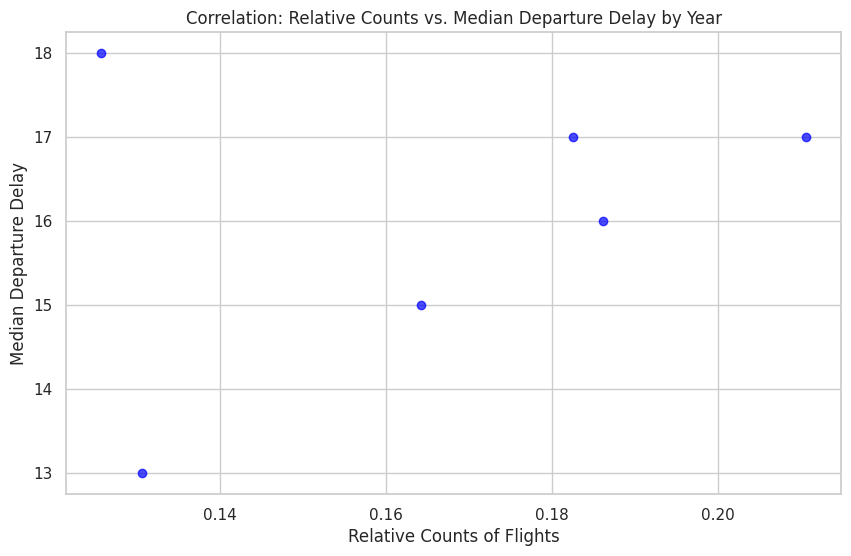

In [145]:
# Create a figure and axis
fig, ax = plt.subplots(figsize=(10, 6))

# Create a scatter plot
ax.scatter(relative_counts, delay_by_year, color='blue', alpha=0.7)
ax.set_xlabel('Relative Counts of Flights')
ax.set_ylabel('Median Departure Delay')
ax.set_title('Correlation: Relative Counts vs. Median Departure Delay by Year')
ax.grid(True)

# Save the plot to a PDF
plt.savefig('Correlation_Relative_Count_vs_Median_Delay_by_Year.pdf')

# Show the plot
plt.show()

In [176]:
filtered_df1 = merged_df[~merged_df['Year_x'].isin([2020, 2021])]

filtered_df1 = filtered_df1[filtered_df1['DepDelay'] > 0]

delay_by_airline_1 = filtered_df1.groupby('Marketing_Airline_Network')['DepDelay'].mean()

airline_counts = filtered_df1['Marketing_Airline_Network'].value_counts()
relative_counts = airline_counts / len(filtered_df1)
# Sort the dataframes for plotting
relative_counts = relative_counts.sort_index()
delay_by_airline_1 = delay_by_airline_1.sort_index()



In [170]:
threshold = relative_counts.quantile(0.70)

# Categorize airlines based on the threshold
large_airlines = list(relative_counts[relative_counts >= threshold].index)
small_airlines = list(relative_counts[relative_counts < threshold].index)

# Display the counts and lists of small and large airlines
print("Large Airlines (top quartile):", large_airlines)
print("Small Airlines (bottom three quartiles):", small_airlines)

Large Airlines (top quartile): ['AA', 'DL', 'UA', 'WN']
Small Airlines (bottom three quartiles): ['AS', 'B6', 'F9', 'G4', 'HA', 'NK', 'VX']


In [179]:
# Calculate relative counts and median departure delay by year


delays_1 = delays[~delays['Year'].isin([2020, 2021])]
delays_1['DepDelay'] = delays_1['DepDelay'].apply(lambda x: max(0, x))

yearly_counts = delays_1['Year'].value_counts()
relative_counts = yearly_counts / yearly_counts.sum()

delays_1 = delays_1[delays_1['DepDelay'] > 0]

delay_by_year = delays_1.groupby('Year')['DepDelay'].median()

# Sort the dataframes for plotting
relative_counts = relative_counts.sort_index()
delay_by_year = delay_by_year.sort_index()

/tmp/ipykernel_32/60086414.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  delays_1['DepDelay'] = delays_1['DepDelay'].apply(lambda x: max(0, x))


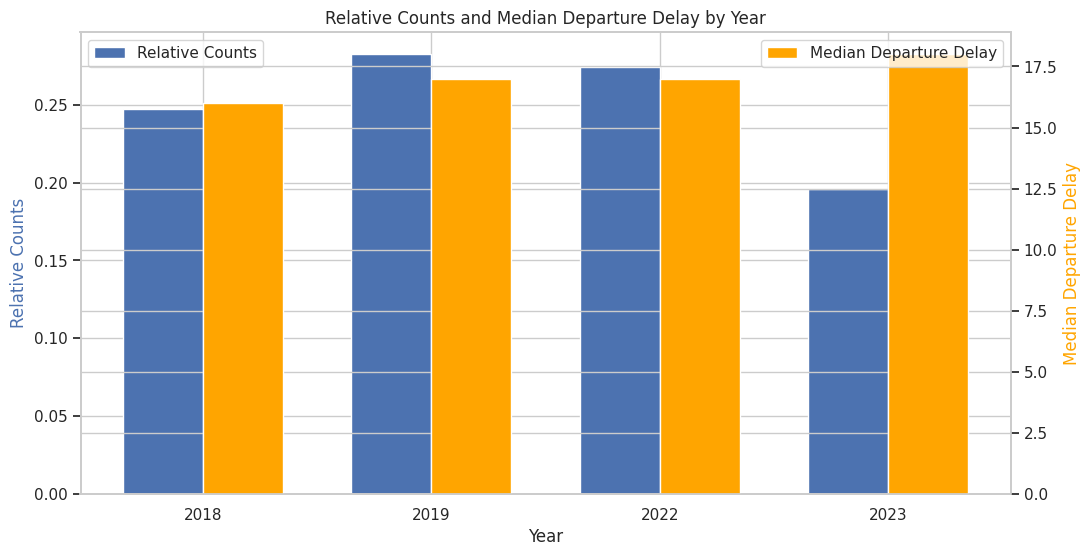

In [180]:
# Create a figure and primary axis
fig, ax1 = plt.subplots(figsize=(12, 6))

# Create an array of x values for the bars
x = range(len(relative_counts))

# Set the bar width
bar_width = 0.35

# Plot Relative Counts on the primary y-axis
ax1.bar(x, relative_counts.values, bar_width, color='b', label='Relative Counts')
ax1.set_xlabel('Year')
ax1.set_ylabel('Relative Counts', color='b')
ax1.set_xticks([i + bar_width / 2 for i in x])
ax1.set_xticklabels(relative_counts.index, rotation=0)

# Create a secondary axis for Median Departure Delay
ax2 = ax1.twinx()
ax2.bar([i + bar_width for i in x], delay_by_year.values, bar_width, color='orange', label='Median Departure Delay')
ax2.set_ylabel('Median Departure Delay', color='orange')

# Set the title
plt.title('Relative Counts and Median Departure Delay by Year')

# Add legends for both axes
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

# Save the plot to a PDF
plt.savefig('Relative_Count_and_Median_Delay_by_Year.pdf')

# Show the plot
plt.show()

In [181]:
correlation_data = pd.DataFrame({'Relative Counts': relative_counts, 'Median Departure Delay': delay_by_year})

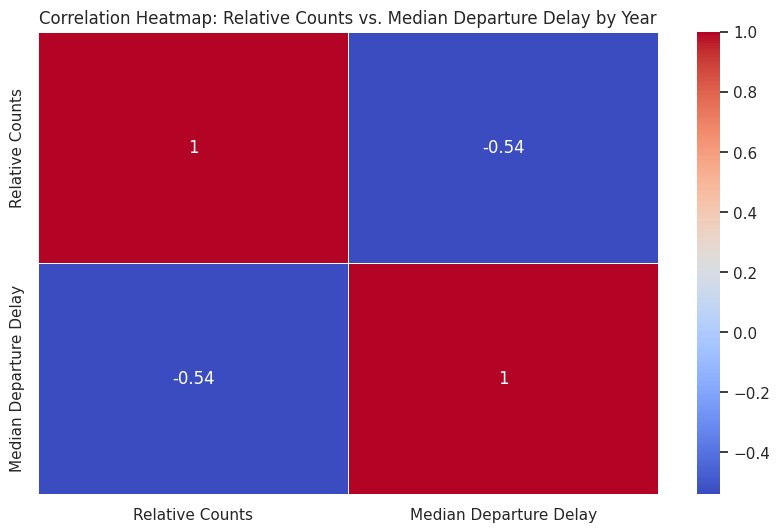

In [182]:
# Create a figure and axis
fig, ax = plt.subplots(figsize=(10, 6))

# Create a correlation heatmap
sns.heatmap(correlation_data.corr(), annot=True, cmap='coolwarm', linewidths=.5, ax=ax)
ax.set_title('Correlation Heatmap: Relative Counts vs. Median Departure Delay by Year')

# Save the heatmap to a PDF
plt.savefig('Correlation_Heatmap_Relative_Count_vs_Median_Delay.pdf')

# Show the heatmap
plt.show()

**Monthly Trend**

In [148]:
merged_df = pd.merge(df, delays, left_index=True, right_index=True)



In [158]:
merged_df = merged_df[merged_df['Year_x'] != 2023]


In [159]:
flight_counts = merged_df.groupby('Month')['DepDelay'].count().reset_index()

# Rename the 'DepDelay' column to 'TotalFlights'
flight_counts.rename(columns={'DepDelay': 'TotalFlights'}, inplace=True)

filtered_df = merged_df[merged_df['DepDelay'] > 0]

# Calculate the median of the remaining DepDelay values
delay_by_month = filtered_df.groupby('Month')['DepDelay'].median()

merged_data = pd.merge(delay_by_month, flight_counts, left_index=True, right_on='Month')

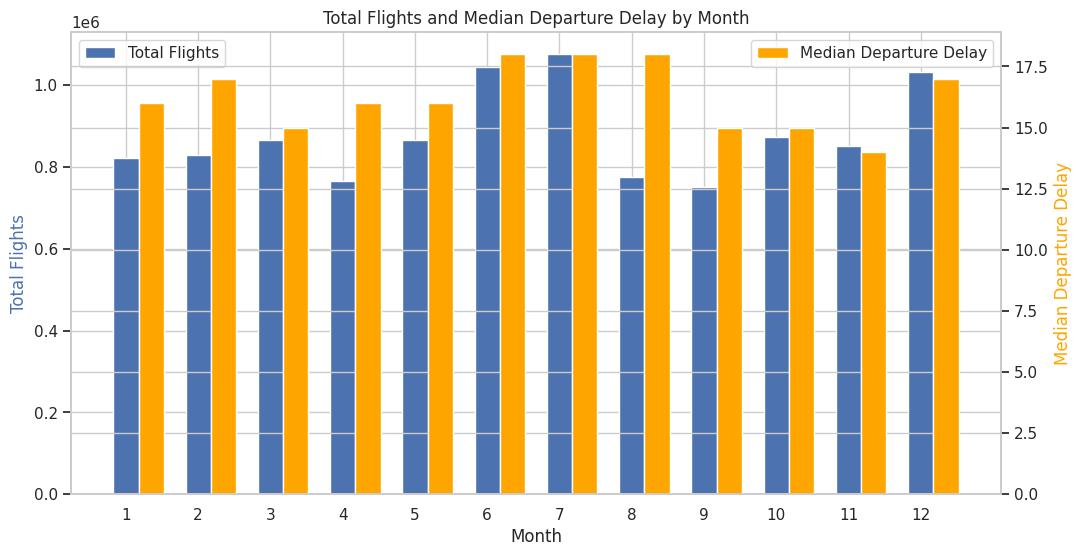

In [160]:
# Create a figure and primary axis
fig, ax1 = plt.subplots(figsize=(12, 6))

# Create an array of x values for the bars
x = range(len(flight_counts))

# Set the bar width
bar_width = 0.35

# Plot Total Flights on the primary y-axis
ax1.bar(x, flight_counts['TotalFlights'], bar_width, color='b', label='Total Flights')
ax1.set_xlabel('Month')
ax1.set_ylabel('Total Flights', color='b')
ax1.set_xticks([i for i in x])
ax1.set_xticklabels([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12], rotation=0)  # Assuming numeric months

# Create a secondary axis for Median Departure Delay
ax2 = ax1.twinx()
ax2.bar([i + bar_width for i in x], delay_by_month.values, bar_width, color='orange', label='Median Departure Delay')
ax2.set_ylabel('Median Departure Delay', color='orange')

# Set the title
plt.title('Total Flights and Median Departure Delay by Month')

# Add legends for both axes
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

# Save the plot to a PDF
plt.savefig('Grouped_Bar_Chart_Monthly.pdf')

# Show the plot
plt.show()

In [163]:
# # Create a figure and axis for the scatter plot
# fig, ax = plt.subplots(figsize=(10, 6))

# # Create a scatter plot
# ax.scatter(flight_counts['TotalFlights'], delay_by_month, color='blue', alpha=0.7)
# ax.set_xlabel('Total Flights per Month')
# ax.set_ylabel('Median Departure Delay')
# ax.set_title('Relationship between Total Flights and Median Departure Delay by Month')
# ax.grid(True)

# # Save the scatter plot to a PDF
# plt.savefig('Scatter_Plot_Monthly.pdf')

# # Show the scatter plot
# plt.show()

In [164]:
# # Create a figure and axis for the correlation heatmap
# fig, ax = plt.subplots(figsize=(10, 6))

# # Create a correlation heatmap
# sns.heatmap(merged_data[['TotalFlights', 'DepDelay']].corr(), annot=True, cmap='coolwarm', linewidths=.5, ax=ax)
# ax.set_title('Correlation Heatmap: Total Flights Monthly vs. Median Departure Delay')

# # Save the heatmap to a PDF
# plt.savefig('Correlation_Heatmap_Monthly.pdf')

# # Show the heatmap
# plt.show()

**Origin City Name**

In [152]:
merged_df = pd.merge(df, delays, left_index=True, right_index=True)

flight_counts = merged_df.groupby('OriginCityName')['DepDelay'].count().reset_index()

# Rename the 'DepDelay' column to 'TotalFlights'
flight_counts.rename(columns={'DepDelay': 'TotalFlights'}, inplace=True)

filtered_df = merged_df[merged_df['DepDelay'] > 0]

origin_counts = df['OriginCityName'].value_counts()

top_origin_cities = origin_counts.head(50).index

top_origin_df = filtered_df[filtered_df['OriginCityName'].isin(top_origin_cities)]

delay_by_origin = top_origin_df.groupby('OriginCityName')['DepDelay'].median()

delay_by_origin = delay_by_origin.loc[top_origin_cities]

merged_data = pd.merge(delay_by_origin, flight_counts, left_index=True, right_on='OriginCityName')

In [153]:
flight_counts

,OriginCityName,TotalFlights
0,"Aberdeen, SD",810
1,"Abilene, TX",2642
2,"Adak Island, AK",286
3,"Aguadilla, PR",4456
4,"Akron, OH",7256
...,...,...
377,"Wrangell, AK",862
378,"Yakima, WA",1295
379,"Yakutat, AK",980
380,"Youngstown/Warren, OH",2


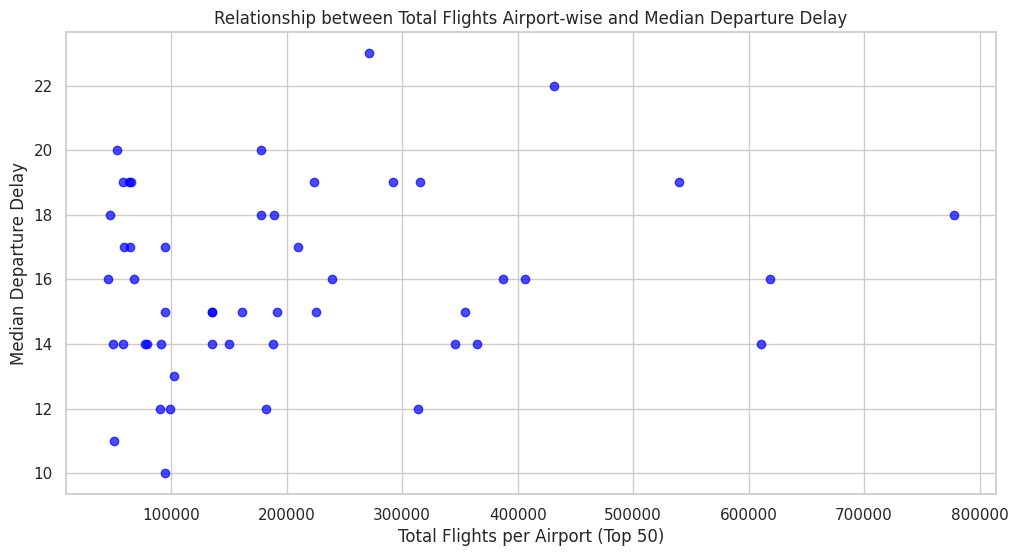

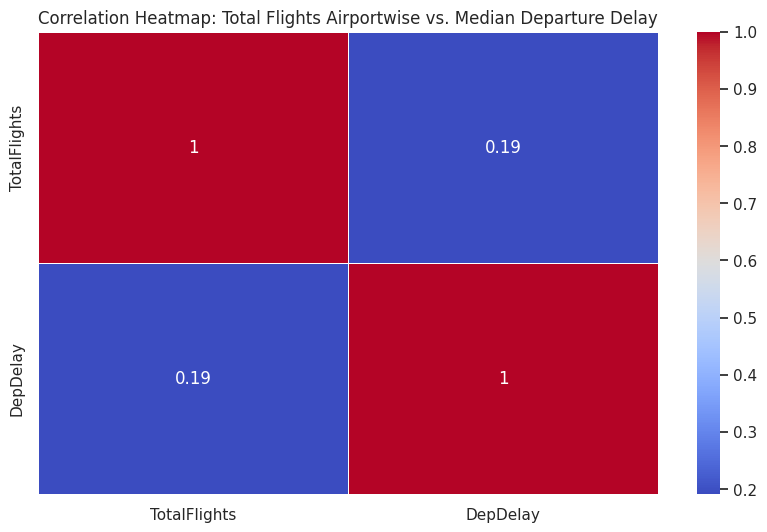

In [154]:
plt.figure(figsize=(12, 6))
plt.scatter(merged_data['TotalFlights'], merged_data['DepDelay'], color='blue', alpha=0.7)
plt.xlabel('Total Flights per Airport (Top 50)')
plt.ylabel('Median Departure Delay')
plt.title('Relationship between Total Flights Airport-wise and Median Departure Delay')
plt.grid(True)

# Create a new DataFrame for the correlation matrix
correlation_data = merged_data[['TotalFlights', 'DepDelay']]

plt.figure(figsize=(10, 6))
sns.heatmap(correlation_data.corr(), annot=True, cmap='coolwarm', linewidths=.5)
plt.title('Correlation Heatmap: Total Flights Airportwise vs. Median Departure Delay')
plt.savefig('Correlation Heatmap Airportwise.pdf')
plt.show()

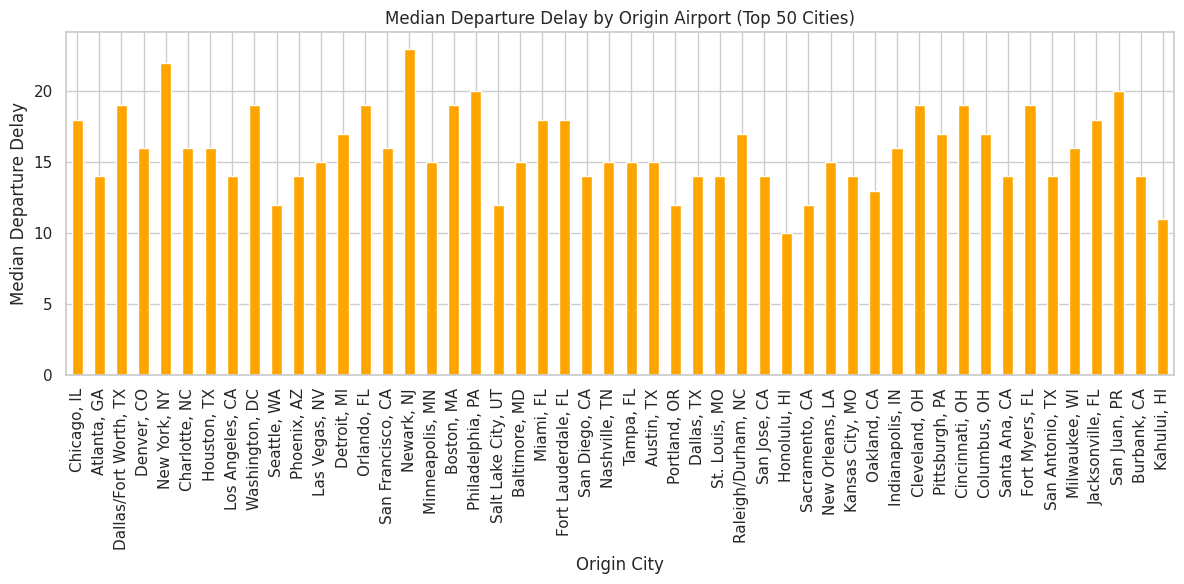

In [155]:
plt.figure(figsize=(12, 6))
delay_by_origin.plot(kind='bar', color='orange')
plt.xlabel('Origin City')
plt.ylabel('Median Departure Delay')
plt.title('Median Departure Delay by Origin Airport (Top 50 Cities)')
plt.xticks(rotation=90)
plt.tight_layout()
plt.savefig('Median_Departure_Delay_by_Top_50_Origin.pdf')
# Show the graph
plt.show()